In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

# In this notebook, we quantify the active tile threshold in the GCN4 ortholog screen

In the process of renormalizing a single library, we:<br><br>

(1) fit a one-sided gaussian to all data less than the activation score at which we have the most tiles. <br>
(2) extend this to a two-sided gaussian, which is the inactive tile distribution<br>
(3) calculate p-values for each tile given the inactive tile distribution as null hypothesis
(4) multiple comparisons correct the resulting p-values


In [2]:
data_dir = "/Users/aaronfultineer/Desktop/Grad School/2023/Fall/Rotations/Staller/data/"

# The data!

In [3]:
gcn4Data = pd.read_csv(data_dir+"Gcn4OrthologData_ToShare_20230414.csv",index_col=0).drop('Unnamed: 0.1',axis=1).drop('Unnamed: 0',axis=1)
gcn4Data = gcn4Data[gcn4Data['Activity_SCglucose'].notna()]
gcn4Data.head()

,ADseq,Name,ArrayDNA,Activity_SCglucose,TotalReads_SCglucose,Activity_SCglucose_GFP1,TotalReads_SCglucoseGFP1,Activity_SCglucose_GFP2,TotalReads_SCglucoseGFP2,Activity_SCgalactose,...,S,T,V,W,Y,Aromatics,WFYL,WFL,WFYLM,WF
0,MALRIEVYNRIESSTASTALQRQDLRYTFRSNARAASGQA,Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g_1,ATGGCTTTGAGAATTGAAGTTTATAATAGAATTGAATCTTCTACTG...,50935.245398,6457.0,1971.036061,3408.0,1531.945159,4802.0,131900.659830,...,5,3,1,0,2,3,6,4,7,1
1,EVYNRIESSTASTALQRQDLRYTFRSNARAASGQANANYQ,Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g_6,GAAGTTTATAATAGAATTGAATCTTCTACTGCTTCTACTGCTTTGC...,22071.199847,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,5,3,1,0,3,4,6,3,6,1
2,IESSTASTALQRQDLRYTFRSNARAASGQANANYQAFTAG,Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g_11,ATTGAATCTTCTACTGCTTCTACTGCTTTGCAAAGACAAGATTTGA...,25945.038091,15804.0,2068.805513,11299.0,1768.287630,11111.0,22684.856992,...,5,4,0,0,2,4,6,4,6,2
3,ASTALQRQDLRYTFRSNARAASGQANANYQAFTAGSALNG,Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g_16,GCTTCTACTGCTTTGCAAAGACAAGATTTGAGATATACATTTAGAT...,22474.232291,6116.0,1891.851800,4249.0,1342.005707,4485.0,30918.404118,...,4,3,0,0,2,4,7,5,7,2
4,QRQDLRYTFRSNARAASGQANANYQAFTAGSALNGPSLPA,Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g_21,CAAAGACAAGATTTGAGATATACATTTAGATCTAATGCTAGAGCTG...,51467.136590,1811.0,1798.615178,935.0,856.038314,701.0,54262.181391,...,4,2,0,0,2,4,7,5,7,2


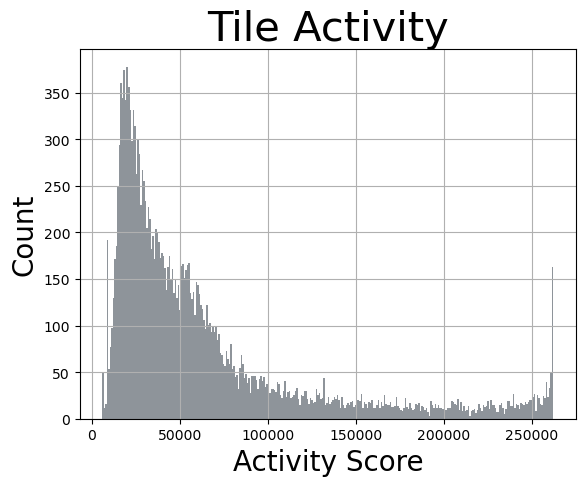

In [22]:
gcn4Data.hist('Activity_SCglucose', bins=300,color='#8E949A') #arbitrary large clean number for bin count
plt.title("Tile Activity", fontsize=30)
plt.xlabel("Activity Score", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.show()

# Now we find our noise!

Fitted parameters:
Amplitude: 377.45658999478957
Mean: 20218.275284705607
Sigma: 5568.6525214363755


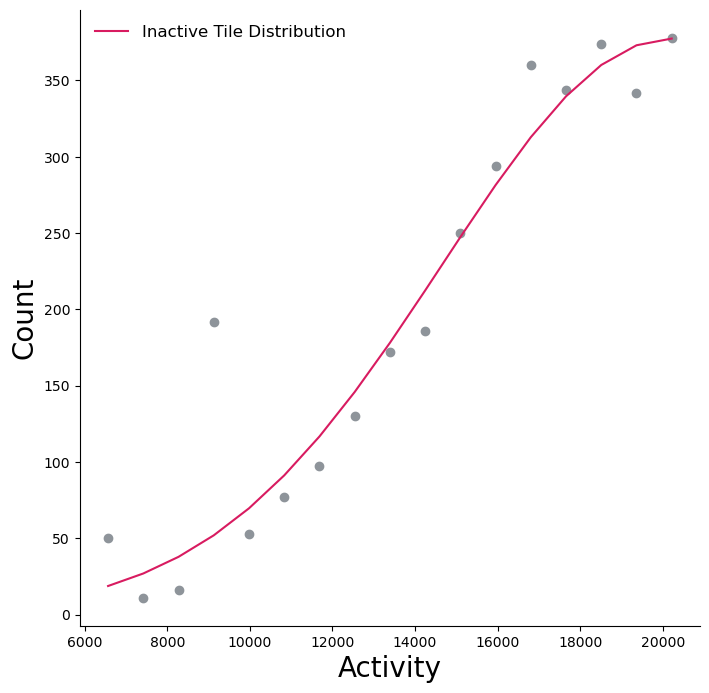

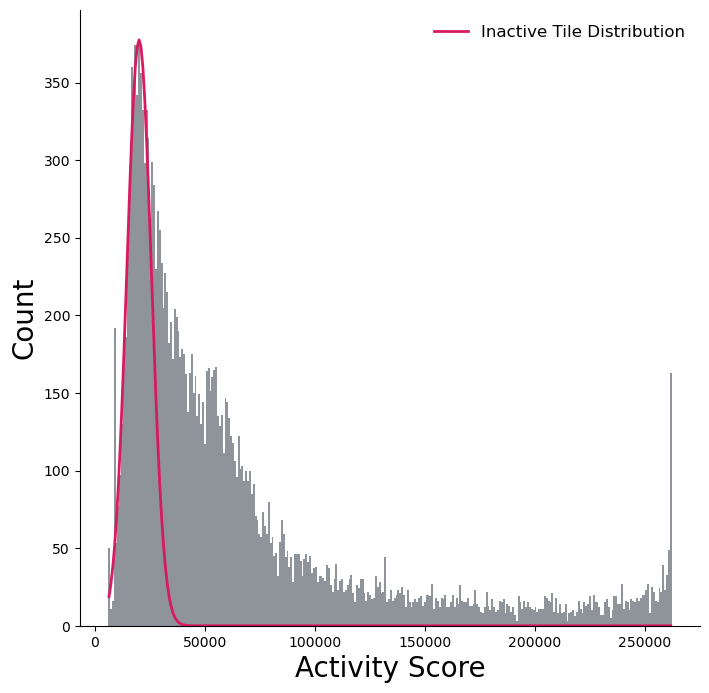

num tot: 19099

num hits (0.01 FDR cutoff): 11579
frac hits FDR: 0.6062621079637678
activity threshold (0.01 FDR) 33820.6452187906

num hits (0.01 FWER cutoff): 8892
frac hits FWER: 0.4655741138279491
activity threshold (0.01 FWER) 47196.9544698306

num hits (0.05 FDR cutoff): 12550
frac hits FDR: 0.6571024660977014
activity threshold (0.05 FDR) 30008.96454495246

num hits (0.05 FWER cutoff): 9210
frac hits FWER: 0.4822242002199068
activity threshold (0.01 FWER) 45372.9460006353


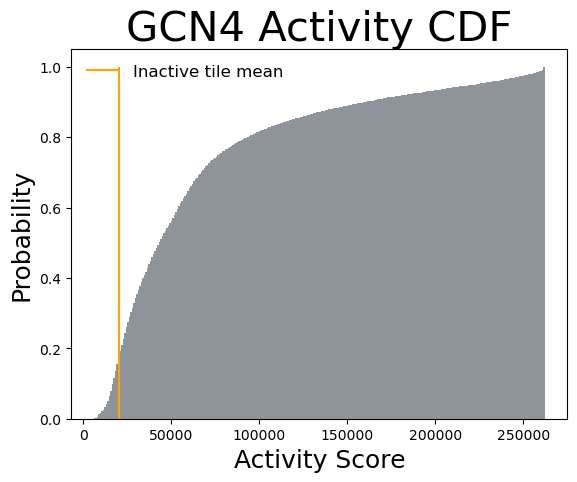

In [30]:
"""
Much of this code was written by prompting chatGPT
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.stats as stats

def one_sided_gaussian(x, amplitude, mean, sigma):
    return amplitude * np.exp(-0.5 * ((x - mean) / sigma)**2) * (x < mean)

def two_sided_gaussian(x, amplitude, mean, sigma):
    return amplitude * np.exp(-0.5 * ((x - mean) / sigma)**2)

bin_num=300

"""
First, find the bin with maximum height
"""
#grab the tile activities from the dataframe and filter out nans
arrayOfTileActivities = gcn4Data['Activity_SCglucose']
arrayOfTileActivities = arrayOfTileActivities[arrayOfTileActivities.notna()].reset_index(drop=True)

#get the bin data from the histogram of tile activities
bin_heights, bin_edges = np.histogram(arrayOfTileActivities, bins=bin_num)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
histogramPoints = np.array(list(zip(bin_centers,bin_heights))) #x and y position of each bin

#get the activitiy value of the bin with the maximum height
maxCountIndex = bin_heights.argmax()
maxActivityValue = bin_centers[maxCountIndex]

"""
Second, grab all bins less than or equal to this peak and fit a one sided Gaussian
"""
thresholdedActivity= [x[0] for x in histogramPoints[np.where(histogramPoints[:, 0] <= maxActivityValue)]]
thresholdedHeights = [x[1] for x in histogramPoints[np.where(histogramPoints[:, 0] <= maxActivityValue)]]

#fit the thresholded data to the one-sided Gaussian function
initial_guess = [400, maxActivityValue, 5000]  # Initial guess for amplitude, mean, and sigma of fit gaussian
popt, pcov = curve_fit(one_sided_gaussian, thresholdedActivity, thresholdedHeights, p0=initial_guess)
amplitude_fit, mean_fit, stdDev_fit = popt

print("Fitted parameters:")
print("Amplitude:", amplitude_fit)
print("Mean:", mean_fit)
print("Sigma:", stdDev_fit)

#plot this fit
fig = plt.figure(figsize=(8,8))
plt.scatter(thresholdedActivity, thresholdedHeights,color='#8E949A')
plt.plot(thresholdedActivity, one_sided_gaussian(thresholdedActivity, *popt), color='#D81B60',label='Inactive Tile Distribution')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Activity',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.legend(frameon=False,fontsize='large')
plt.savefig("figureS?A.pdf",format='pdf')
plt.show()

"""
Third, plot the extended two sided Gaussian over the histogram
"""
# Plot histogram and fitted Gaussian
fig = plt.figure(figsize=(8,8))
plt.hist(arrayOfTileActivities,bins=bin_num,color='#8E949A')
plt.plot(bin_centers, two_sided_gaussian(bin_centers, *popt), color='#D81B60',label='Inactive Tile Distribution',linewidth=2)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Activity Score',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.legend(frameon=False,fontsize='large')
plt.savefig("figureS?B.pdf",format='pdf')
plt.show()

"""
Fourth, using this noise Gaussian as the null hypothesis, find an FDR-corrected p-value for each tile
"""
#returns p val for a data point given underlying null gaussian
def p_values_from_normal_distribution(data, mean, std_dev):
    p_values = [stats.norm.cdf(x, loc=mean, scale=std_dev) for x in data]
    return p_values

cutoffTileActivities = arrayOfTileActivities[arrayOfTileActivities>=mean_fit]  

idk = gcn4Data[gcn4Data['Activity_SCglucose']>=mean_fit]
idk['p-val'] = np.ones(len(cutoffTileActivities))-p_values_from_normal_distribution(cutoffTileActivities,mean_fit,stdDev_fit)
idk['FDR'] = stats.false_discovery_control(idk['p-val'])

print("num tot:", len(gcn4Data))
print()
print("num hits (0.01 FDR cutoff):", len(idk[idk['FDR']<0.01]))
print("frac hits FDR:", len(idk[idk['FDR']<0.01])/len(gcn4Data))
print("activity threshold (0.01 FDR)", idk.sort_values('p-val').reset_index(drop=True).iloc[len(idk[idk['FDR']<0.01])]['Activity_SCglucose'])
print()
print("num hits (0.01 FWER cutoff):", len(idk[idk['p-val']<0.01/len(idk)]))
print("frac hits FWER:", len(idk[idk['p-val']<0.01/len(idk)])/len(gcn4Data))
print("activity threshold (0.01 FWER)", idk.sort_values('p-val').reset_index(drop=True).iloc[len(idk[idk['p-val']<0.01/len(idk)])]['Activity_SCglucose'])
print()
print("num hits (0.05 FDR cutoff):", len(idk[idk['FDR']<0.05]))
print("frac hits FDR:", len(idk[idk['FDR']<0.05])/len(gcn4Data))
print("activity threshold (0.05 FDR)", idk.sort_values('p-val').reset_index(drop=True).iloc[len(idk[idk['FDR']<0.05])]['Activity_SCglucose'])
print()
print("num hits (0.05 FWER cutoff):", len(idk[idk['p-val']<0.05/len(idk)]))
print("frac hits FWER:", len(idk[idk['p-val']<0.05/len(idk)])/len(gcn4Data))
print("activity threshold (0.01 FWER)", idk.sort_values('p-val').reset_index(drop=True).iloc[len(idk[idk['p-val']<0.05/len(idk)])]['Activity_SCglucose'])

plt.hist(gcn4Data['Activity_SCglucose'], bins=300,density=True,cumulative=True,color='#8E949A')
plt.vlines(ymin=0, ymax=1, x=mean_fit, label="Inactive tile mean", color='orange')
plt.title("GCN4 Activity CDF",fontsize=30)
plt.xlabel("Activity Score",fontsize=18)
plt.ylabel("Probability",fontsize=18)
plt.legend(frameon=False,fontsize='large')
plt.savefig("gcn4_CDF.pdf",format='pdf')
plt.show()

## So, if we take the 0.01 FDR cutoff we get an active threshold of 33821
## If we take the 0.01 FWER cutoff, we get an active threshold of 45373

In [28]:
search_string = "STDSTPMFEYENLEDNSKEWTSLFDNDIPVTTDDVSLADK"
bool_df = gcn4Data.map(lambda x: isinstance(x, str) and search_string in x)
positions = list(zip(*np.where(bool_df)))

print("Positions where the string is found:", positions)
print("Values at those positions:", [gcn4Data.iat[i, j] for i, j in positions])

gcn4Data.iloc[19050]['Activity_SCglucose']

Positions where the string is found: [(15636, 0), (19050, 0)]
Values at those positions: ['STDSTPMFEYENLEDNSKEWTSLFDNDIPVTTDDVSLADK', 'STDSTPMFEYENLEDNSKEWTSLFDNDIPVTTDDVSLADK']


137976.9357086746

# Generate final figure

So, we have all the ingredients! The histogram, the noise profile, and p-values for each tile. We now set our FDR-corrected p-value threshold at 0.05, setting our total false positive rate to 5%, and plot!

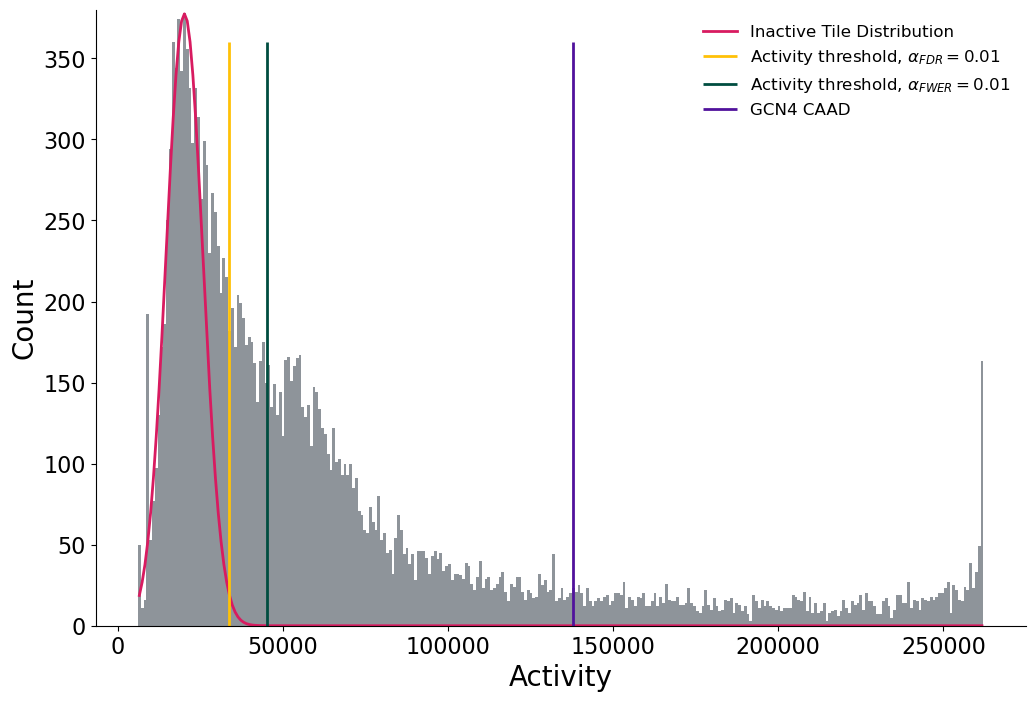

In [31]:
# Plot histogram and fitted Gaussian
fig = plt.figure(figsize=(12,8))
plt.hist(arrayOfTileActivities,bins=bin_num,color='#8E949A')
plt.ylim(0,380)
plt.plot(bin_centers, two_sided_gaussian(bin_centers, *popt), color='#D81B60',label='Inactive Tile Distribution',linewidth=2)

plt.vlines(x=33821,ymin=0,ymax=360,color='#FFC107',label=r'Activity threshold, $\alpha_{FDR}=0.01$',linewidth=2)
plt.vlines(x=45373,ymin=0,ymax=360,color='#004D40',label=r'Activity threshold, $\alpha_{FWER}=0.01$',linewidth=2)
plt.vlines(x=137977,ymin=0,ymax=360,color='#51129C',label='GCN4 CAAD',linewidth=2)

plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=14)

plt.xlabel('Activity',fontsize=20)
plt.ylabel('Count',fontsize=20)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(frameon=False,fontsize='large')
plt.savefig("figure1E.pdf",format='pdf')
plt.show()